
## Drug Activity Prediction

In [1]:
#importing libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, SMOTE, ADASYN, KMeansSMOTE


#disable annoying warnings
import warnings
warnings.filterwarnings("ignore")

RDKit WARNING: [12:08:36] Enabling RDKit 2019.09.3 jupyter extensions
[12:08:36] Enabling RDKit 2019.09.3 jupyter extensions


 ## Data exploration

In [2]:
data = pd.read_csv("data_train.csv", index_col=0)
#data.head()

#upload testset:
test = pd.read_csv('smiles_test.csv')


In [3]:
data.shape

(12000, 12)

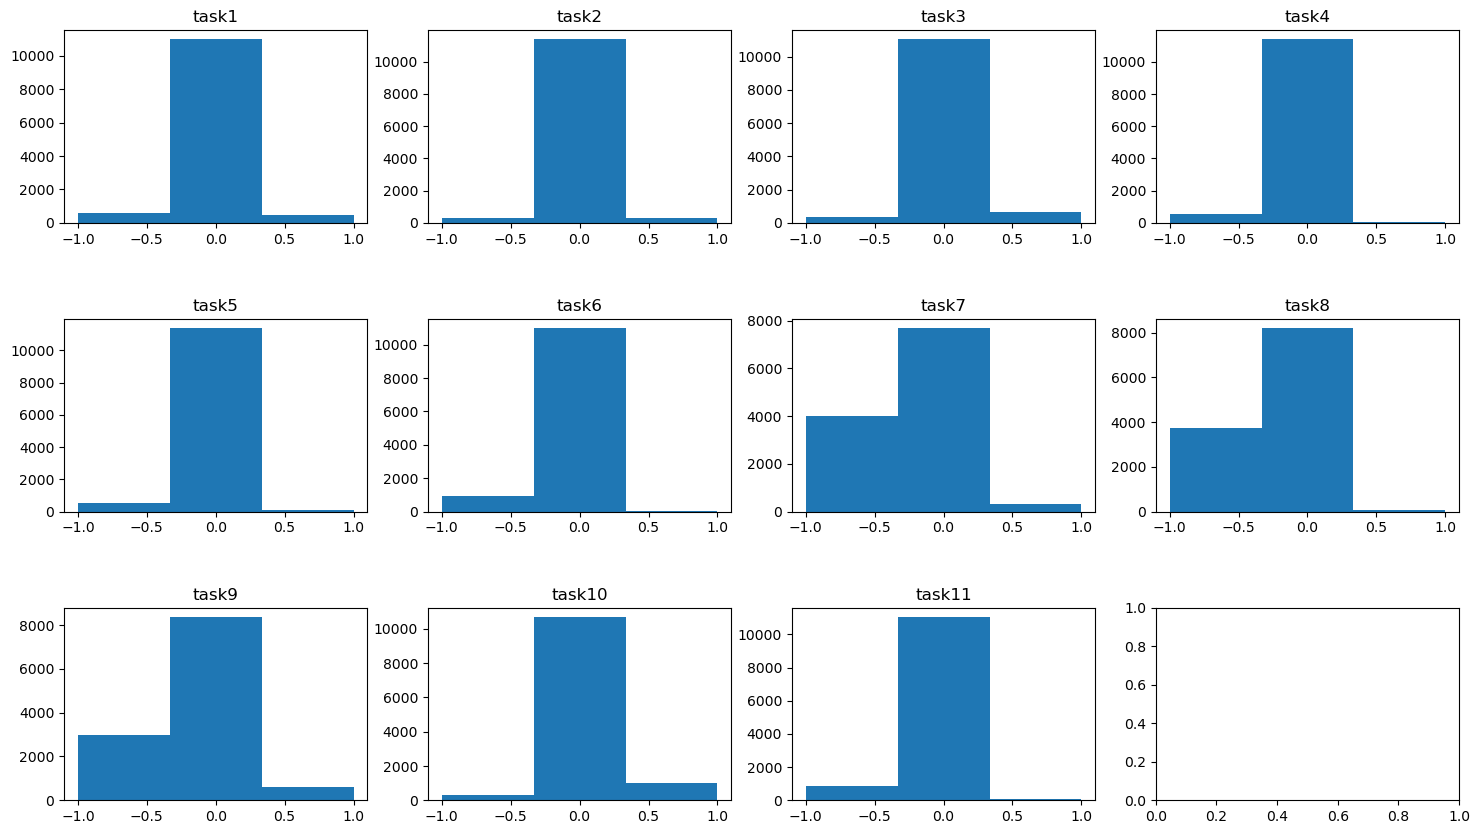

In [4]:
#look at class distribution
tasks = ['task1', 'task2', 'task3', 'task4', 'task5', 'task6', 'task7', 'task8', 'task9', 'task10', 'task11']
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(hspace=0.5)

for i, task in enumerate(tasks):
    row = i // 4
    col = i % 4
    axs[row, col].hist(data[task], bins=3)
    axs[row, col].set_title(task)
    
plt.show() #very unbalanced data


In [5]:
task_cols = data.columns[1:]
# Iterate over the task columns and count the number of -1, 0, and 1 labels
for col in task_cols:
    counts = data[col].value_counts()
    sum = counts[-1] + counts[0] + counts[1]
    print(f"Task: {col}")
    print(f"-1: {round(counts[-1]/sum, 3)}, 0: {round(counts[0]/sum, 3)}, 1: {round(counts[1]/sum, 3)}")
    

Task: task1
-1: 0.047, 0: 0.915, 1: 0.038
Task: task2
-1: 0.026, 0: 0.947, 1: 0.026
Task: task3
-1: 0.027, 0: 0.92, 1: 0.053
Task: task4
-1: 0.047, 0: 0.949, 1: 0.004
Task: task5
-1: 0.042, 0: 0.947, 1: 0.01
Task: task6
-1: 0.079, 0: 0.916, 1: 0.005
Task: task7
-1: 0.334, 0: 0.641, 1: 0.026
Task: task8
-1: 0.313, 0: 0.683, 1: 0.004
Task: task9
-1: 0.25, 0: 0.698, 1: 0.052
Task: task10
-1: 0.026, 0: 0.89, 1: 0.084
Task: task11
-1: 0.073, 0: 0.921, 1: 0.006


## Data preprocessing

The idea is to get rid of all unknown samples so that we only have label -1 and 1 and proceed to resample using [SMOTE borderline](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html) : 

In [6]:
#set all zero values to Nan
data = data.replace(0, None)
 

In [7]:
task_cols = data.columns[1:]
# Iterate over the task columns and count the number of -1 and 1 labels
for col in task_cols:
    counts = data[col].value_counts()
    
    print(f"Task: {col}")
    print(f"-1: {round(counts[-1])}, 1: {round(counts[1])}")
    print(f"Total: {round(counts[-1] + counts[1])}")

Task: task1
-1: 561, 1: 462
Total: 1023
Task: task2
-1: 316, 1: 316
Total: 632
Task: task3
-1: 325, 1: 637
Total: 962
Task: task4
-1: 564, 1: 46
Total: 610
Task: task5
-1: 510, 1: 122
Total: 632
Task: task6
-1: 950, 1: 60
Total: 1010
Task: task7
-1: 4005, 1: 306
Total: 4311
Task: task8
-1: 3756, 1: 48
Total: 3804
Task: task9
-1: 3002, 1: 624
Total: 3626
Task: task10
-1: 310, 1: 1004
Total: 1314
Task: task11
-1: 880, 1: 73
Total: 953


Now I'm gonna divide the task and make a dictionary in which for each task only numerical values are saved, so that we can finally apply SMOTE


In [8]:
dfs = {}

# iterate over the task columns and create a new dataframe for each, exclude unknown values
for task in data.columns[1:]:
    task_df = data.loc[data[task].isin([-1, 1]), ['smiles', task]]
    dfs[task] = task_df


In [9]:
#convert smiles into canonical smiles form, and then translate it to Morgan fingerprints
for task in dfs:
    dfs[task]['can_smiles'] = dfs[task]['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False, canonical=True))
    dfs[task]['fp'] = dfs[task]['can_smiles'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 4, nBits=1024))
    dfs[task] = dfs[task].drop(['smiles', 'can_smiles'], axis=1)
    
    


In [10]:
#do the same for the testset
test_data = test['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False, canonical=True))
test_data = test_data.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 4, nBits=1024))
test_data = pd.DataFrame(test_data)
test_data

,smiles
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
5891,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
5892,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5893,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
5894,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
#save dfs in csv for further processing
for task in dfs:
    dfs[task].to_csv(f"task_{task}.csv")

In [12]:
#dfs

In [13]:
sm = SVMSMOTE(random_state=42)

In [14]:
#use svmsmote to oversample the data
for task in dfs:
    X = np.vstack(dfs[task]['fp'].values) # convert to a binary matrix
    X = X.astype(int)
    y = dfs[task][task].values
    y = y.astype(int)
    X_res, y_res = sm.fit_resample(X, y)
    dfs[task] = pd.DataFrame({'fp': X_res.tolist(), task: y_res})

In [15]:
# Iterate over the task of dfs and count the number of -1 and 1 labels
for task in dfs:
    counts = dfs[task][task].value_counts()
    sum = counts[-1] + counts[1]
    print(f"Task: {task}")
    print(f"-1: {round(counts[-1]/sum, 3)} ({round(counts[-1])}) , 1: {round(counts[1]/sum, 3)} ({round(counts[1])})") #almost perfectly balanced

Task: task1
-1: 0.5 (561) , 1: 0.5 (561)
Task: task2
-1: 0.5 (316) , 1: 0.5 (316)
Task: task3
-1: 0.5 (637) , 1: 0.5 (637)
Task: task4
-1: 0.5 (564) , 1: 0.5 (564)
Task: task5
-1: 0.604 (510) , 1: 0.396 (335)
Task: task6
-1: 0.633 (950) , 1: 0.367 (550)
Task: task7
-1: 0.631 (4005) , 1: 0.369 (2340)
Task: task8
-1: 0.643 (3756) , 1: 0.357 (2087)
Task: task9
-1: 0.5 (3002) , 1: 0.5 (3002)
Task: task10
-1: 0.5 (1004) , 1: 0.5 (1004)
Task: task11
-1: 0.63 (880) , 1: 0.37 (517)


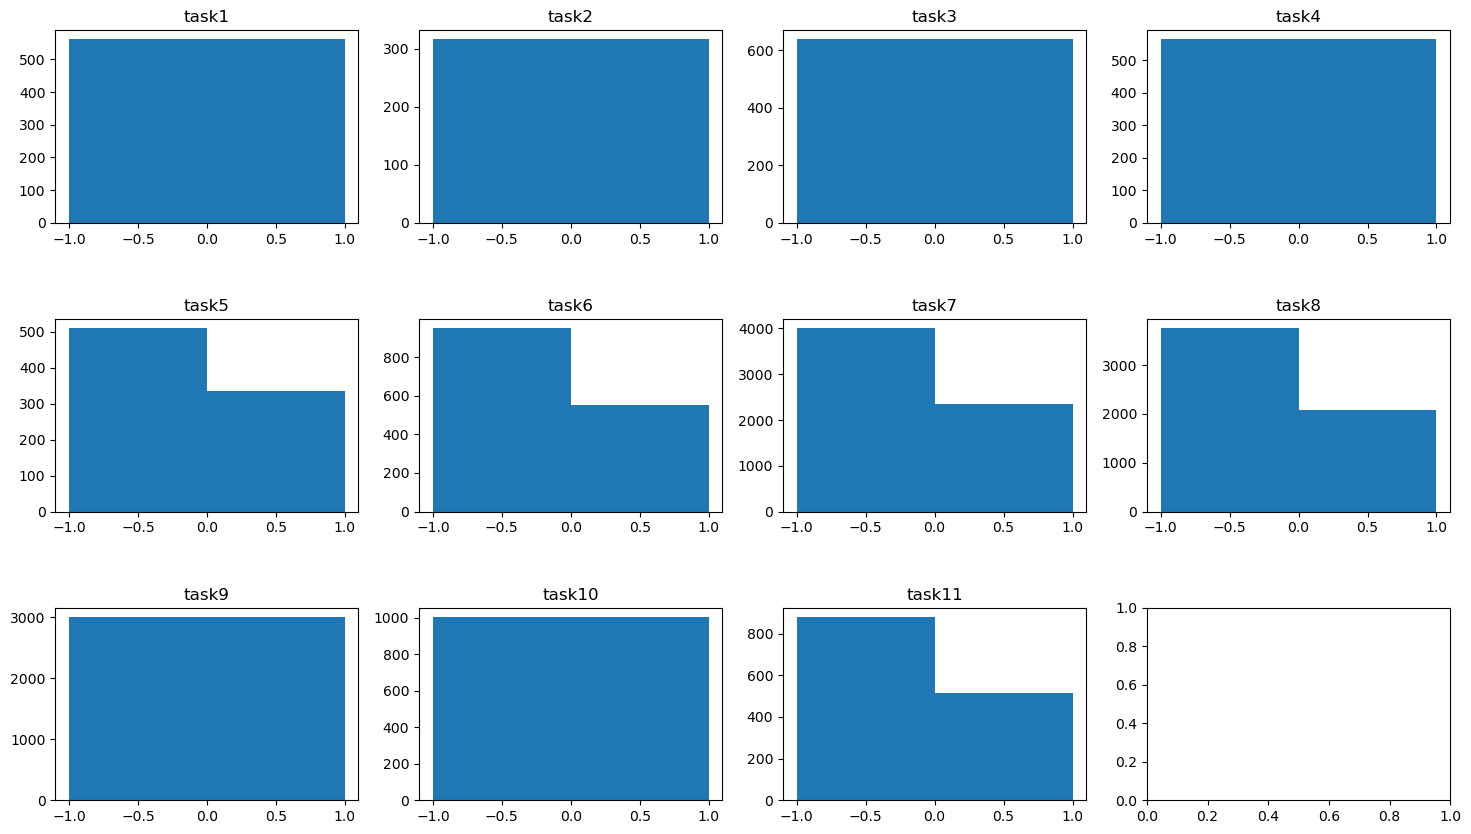

In [16]:
#look at class distribution
tasks = ['task1', 'task2', 'task3', 'task4', 'task5', 'task6', 'task7', 'task8', 'task9', 'task10', 'task11']
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(hspace=0.5)

for i, task in enumerate(tasks):
    row = i // 4
    col = i % 4
    axs[row, col].hist(dfs[task][task], bins=2)
    axs[row, col].set_title(task)
    labels = ['1', '-1']
    
    
plt.show() #way more balanced now


## Training

Now 11 models are trained, one for each task.


<b>RANDOM FOREST

In [17]:
#select the best parameters for the random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth= 8, min_samples_leaf= 2, min_samples_split= 5, random_state=42, n_jobs=-1)

In [18]:
auc = []
for task in dfs:
    X_train, X_test, y_train, y_test = train_test_split(dfs[task]['fp'].to_numpy(), dfs[task][task], test_size=0.2, random_state=42)
    X_train = np.array([np.array(x).astype(np.float) for x in X_train])
    X_test = np.array([np.array(x).astype(np.float) for x in X_test])
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    #print(f"Task: {task}")
    #print(classification_report(y_test, y_pred))
    #print(f"AUC: {roc_auc_score(y_test, y_pred)}")
    auc.append(roc_auc_score(y_test, y_pred))
    #print(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}")
print(np.mean(auc))
    

0.8337245342351768


In [19]:
#grid search for the best parameters
for task in dfs:
    X_train, X_test, y_train, y_test = train_test_split(dfs[task]['fp'].to_numpy(), dfs[task][task], test_size=0.2, random_state=42)
    X_train = np.array([np.array(x).astype(np.float) for x in X_train])
    X_test = np.array([np.array(x).astype(np.float) for x in X_test])
    rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
    param_grid = {
        'max_depth': [8, 10, 12],
        'min_samples_leaf': [2, 4, 6],
        'min_samples_split': [5, 10, 15]
    }
    grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=10; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=10; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=15; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=10; total time=   0.3s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=15; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=15; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5; total time=   0.2s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5; total time=   0.3s
[CV] END max_depth=8, min_sampl

In [20]:
rf_model2 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth= 12, min_samples_leaf= 2, min_samples_split= 5, random_state=42)

In [21]:
auc = []
for task in dfs:
    X_train, X_test, y_train, y_test = train_test_split(dfs[task]['fp'].to_numpy(), dfs[task][task], test_size=0.2, random_state=42)
    X_train = np.array([np.array(x).astype(np.float) for x in X_train])
    X_test = np.array([np.array(x).astype(np.float) for x in X_test])
    rf_model2.fit(X_train, y_train)
    y_pred = rf_model2.predict(X_test)
    y_pred_proba = rf_model2.predict_proba(X_test)
    #print(f"Task: {task}")
    #print(classification_report(y_test, y_pred))
    #print(f"AUC: {roc_auc_score(y_test, y_pred)}")
    auc.append(roc_auc_score(y_test, y_pred))
    #print(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}")
print(np.mean(auc))

0.8451288936504228


<b>GAUSSIAN NAIVE BAYES

In [22]:
clf = GaussianNB(var_smoothing=0.1)

In [23]:
auc = []
for task in dfs:
    X_train, X_test, y_train, y_test = train_test_split(dfs[task]['fp'].to_numpy(), dfs[task][task], test_size=0.2, random_state=42)
    X_train = np.array([np.array(x).astype(np.float) for x in X_train])
    X_test = np.array([np.array(x).astype(np.float) for x in X_test])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #print(f"Task: {task}")
    #print(classification_report(y_test, y_pred))
    #print(f"AUC: {roc_auc_score(y_test, y_pred)}")
    auc.append(roc_auc_score(y_test, y_pred))
    #print(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}")
print(np.mean(auc))

0.7051572846152987


------------------------------------------------------------------------------------------------------------
## Prediction on test set:

In [24]:
#test_data.shape

RF

In [25]:
task_proba = {}
task_class = {}
#predict the testset
for i,task in enumerate(dfs):
    
    X_train = np.array([np.array(x).astype(np.float) for x in dfs[task]['fp'].to_numpy()])
    #print(X_train.shape)
    y_train = dfs[task][task].values
    #print(y_train.shape)
    X_test = np.array([np.array(x).astype(np.float) for x in test_data['smiles'].to_numpy()])
    #print(X_test.shape)
    
    rf_model2.fit(X_train, y_train)
    y_pred = rf_model2.predict(X_test)
    y_pred_proba = rf_model2.predict_proba(X_test)
    task_proba[task] = y_pred_proba
    task_class[task] = y_pred
    
    

In [26]:
task_proba['task11'] #proability distribution of -1 and 1

array([[0.79360606, 0.20639394],
       [0.80829343, 0.19170657],
       [0.72158523, 0.27841477],
       ...,
       [0.84036348, 0.15963652],
       [0.85747193, 0.14252807],
       [0.67947064, 0.32052936]])

In [27]:
#create dataframe to store probability predictions
df = pd.DataFrame({task: [x[1] for x in task_proba[task]] for task in task_proba})

In [28]:
#sanity check
df.shape

(5896, 11)

In [29]:
#save it as csv file (indexed!)
df.to_csv('output7.csv', index=True)

GNB

In [30]:
task_proba = {}
task_class = {}
#predict the testset
for i,task in enumerate(dfs):
    
    X_train = np.array([np.array(x).astype(np.float) for x in dfs[task]['fp'].to_numpy()])
    #print(X_train.shape)
    y_train = dfs[task][task].values
    #print(y_train.shape)
    X_test = np.array([np.array(x).astype(np.float) for x in test_data['smiles'].to_numpy()])
    #print(X_test.shape)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    task_proba[task] = y_pred_proba
    task_class[task] = y_pred

In [31]:
df_gnb = pd.DataFrame({task: [x[1] for x in task_proba[task]] for task in task_proba})

In [32]:
df_gnb.to_csv('output3.csv', index=True)